<a href="https://colab.research.google.com/github/juanpajaro/IA_en_salud_diplomado_puj/blob/main/clase_2_regression_ml_salud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio
!pip install shap

In [18]:
# imports
import pandas as pd
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
import shap
from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import ensemble, linear_model

In [ ]:
# read in dataset
df = pd.read_csv("LengthOfStay.csv")
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,B,3
1,2,5/26/2012,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,A,7
2,3,9/22/2012,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,B,3
3,4,8/9/2012,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,A,1
4,5,12/20/2012,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,E,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   eid                         100000 non-null  int64  
 1   vdate                       100000 non-null  object 
 2   rcount                      100000 non-null  object 
 3   gender                      100000 non-null  object 
 4   dialysisrenalendstage       100000 non-null  int64  
 5   asthma                      100000 non-null  int64  
 6   irondef                     100000 non-null  int64  
 7   pneum                       100000 non-null  int64  
 8   substancedependence         100000 non-null  int64  
 9   psychologicaldisordermajor  100000 non-null  int64  
 10  depress                     100000 non-null  int64  
 11  psychother                  100000 non-null  int64  
 12  fibrosisandother            100000 non-null  int64  
 13  malnutrition   

#Limpieza de datos

In [ ]:
# type conversions
datetime_cols = ["vdate", "discharged"]
cat_cols = ["gender", "rcount", "facid"]
bin_cols = ["dialysisrenalendstage",
            "asthma",
            "irondef",
            "pneum",
            "substancedependence",
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]
num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "respiration"]

for date_col, cat_col in zip(datetime_cols, cat_cols):
    df[date_col] = pd.to_datetime(df[date_col], format="%m/%d/%Y")
    df[cat_col] = df[cat_col].astype("category")
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,2012-08-29,0,F,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,2012-09-01,B,3
1,2,2012-05-26,5+,F,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,2012-06-02,A,7
2,3,2012-09-22,1,F,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,2012-09-25,B,3
3,4,2012-08-09,0,F,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,2012-08-10,A,1
4,5,2012-12-20,0,F,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,2012-12-24,E,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   eid                         100000 non-null  int64         
 1   vdate                       100000 non-null  datetime64[ns]
 2   rcount                      100000 non-null  category      
 3   gender                      100000 non-null  category      
 4   dialysisrenalendstage       100000 non-null  int64         
 5   asthma                      100000 non-null  int64         
 6   irondef                     100000 non-null  int64         
 7   pneum                       100000 non-null  int64         
 8   substancedependence         100000 non-null  int64         
 9   psychologicaldisordermajor  100000 non-null  int64         
 10  depress                     100000 non-null  int64         
 11  psychother                  100000 non-n

#Ingeniería de caracteristicas

In [ ]:
# number_of_issues transform function
def calculate_number_of_issues(df, bin_cols):
    df["numberofissues"] = df[bin_cols].sum(axis=1)
    return df

df = calculate_number_of_issues(df, bin_cols)

#Ajuste del modelo

In [ ]:
labels, features = df[["lengthofstay"]], df.drop(["lengthofstay", "discharged", "vdate", "eid"], axis=1)
labels.value_counts()

,count
lengthofstay,
1,17979
3,16068
4,14822
2,12825
5,12116
6,10362
7,7263
8,4652
9,2184


In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   rcount                      100000 non-null  category
 1   gender                      100000 non-null  category
 2   dialysisrenalendstage       100000 non-null  int64   
 3   asthma                      100000 non-null  int64   
 4   irondef                     100000 non-null  int64   
 5   pneum                       100000 non-null  int64   
 6   substancedependence         100000 non-null  int64   
 7   psychologicaldisordermajor  100000 non-null  int64   
 8   depress                     100000 non-null  int64   
 9   psychother                  100000 non-null  int64   
 10  fibrosisandother            100000 non-null  int64   
 11  malnutrition                100000 non-null  int64   
 12  hemo                        100000 non-null  int64   
 13  

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels)

In [ ]:
regressor = make_pipeline(
    ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(), cat_cols),
    ], remainder="passthrough"),
    ensemble.GradientBoostingRegressor()
)
regressor.fit(x_train, y_train)
preds = np.round(regressor.predict(x_test), 0)
r2_score(preds, y_test)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


0.9361175956094333

In [ ]:
explainer = shap.Explainer(regressor[1], feature_names=regressor[:-1].get_feature_names_out())

observations = regressor[0].transform(x_test)
shap_values = explainer(observations)
shap_values.shape

(25000, 35)

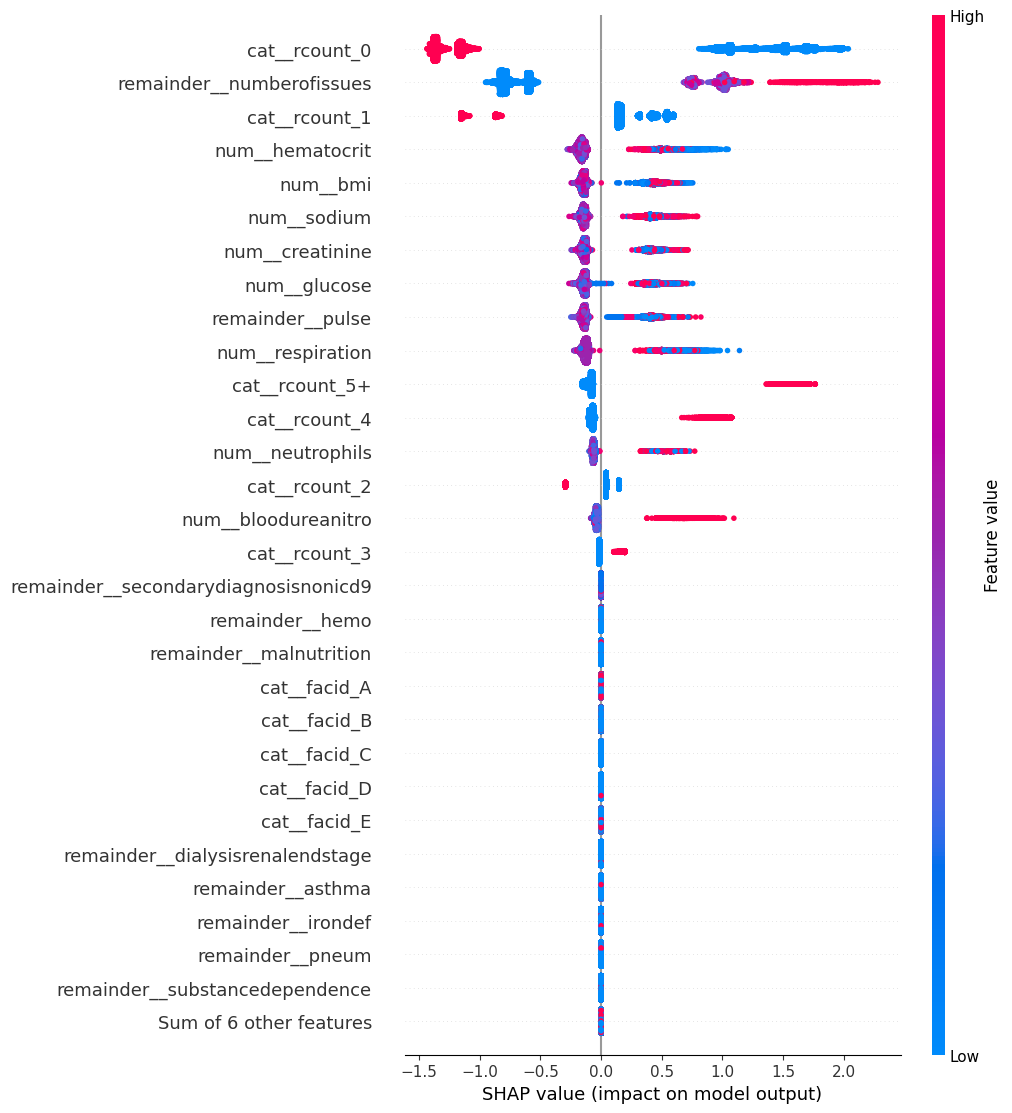

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.plots.beeswarm(shap_values,  max_display=30)
plt.savefig('beeswarm_lengthofstay.jpg')